# Elastic Cross-section Data Comparison

Kurtis Bartlett

2017/3/12

Ipython notebook for generating plot of elastic Aluminum cross-section measurements compared with model.

In [1]:
# Import necessary packages and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Use text and computer modern for text formating
pp.rcParams["text.usetex"] = "True"
pp.rcParams["font.family"] = "serif"
pp.rcParams["font.serif"] = "Computer Modern Roman"
pp.rcParams["font.sans-serif"] = "Computer Modern Sans serif"

In [3]:
# Keep matplotlib plots inline
%matplotlib inline

In [4]:
pp.style.use('seaborn-white')
sns.set_palette("muted")
plot_size = 6*np.array([1.0,(2.0/(1.0+np.sqrt(5.0)))]) #Use Golden ratio as aspect ratio for plots

In [70]:
# Define contants (2014 PDG)
alpha = 1/137.035999074
cc = 197.3269718 # MeV fm
cc_sq = 0.389379338 # GeV^2 mbarn
m_p = 938.272046 # Mev/c^2
J = 5.0/2.0 # Aluminum-27 nuclear spin
Z = 13 # Aluminum # of protons
N = 14 # Aluminum # of neutrons
A = 27 # Aluminum atomic mass
r = 2.98*(1000.0/cc) # [fm]->[1/GeV] RMS radius
a_p_sq = 0.427*(1000.0/cc)*(1000.0/cc) # [fm^2]->[1/GeV^2]
Q = 14.6*(1000.0/cc)*(1000.0/cc) # [fm^2]->[1/GeV^2] Electric quadrupole moment

In [73]:
# Define functions
def q_squared(energy, theta):
    'Energy[GeV], Theta[Degrees]'
    one_vec = np.ones(len(theta))
    numerator = one_vec-np.cos(np.deg2rad(theta))
    denominator = one_vec+(energy/(m_p*one_vec))*numerator
    qq = (2.0*one_vec)*energy*energy*(numerator/denominator)
    return qq

def percent_diff(data, model):
    pdiff = 100*((data-model)/data)
    return pdiff

def mott_xsection(energy, theta):
    'Energy[GeV], Theta[Degrees]'
    one_vec = np.ones(len(theta))
    numerator = alpha*alpha*one_vec*np.cos(np.deg2rad(theta)/(2.0*one_vec))*np.cos(np.deg2rad(theta)/(2.0*one_vec))
    denominator = 4*one_vec*energy*energy*np.power(np.sin(np.deg2rad(theta)/(2.0*one_vec)),4)
    xsection = (1000*cc_sq*one_vec)*(numerator/denominator) #Convert to mubarns/sr
    return xsection

def stovall_xsection(energy, theta):
    'Energy[GeV], Theta[Degrees]'
    one_vec = np.ones(len(theta))
    
    qq = q_squared(energy, theta) # [GeV^2]
    
    kk = qq*np.square(one_vec+((((3.0*Z*alpha)/(2.0*r))*one_vec)/energy)) # [GeV^2]
    
    a_0_sq = (r*r - 1.5*a_p_sq)/(3.5-(10.0/Z)-(3.0/(2.0*A))) # [1/GeV^2]
    
    x = 0.25*one_vec*kk*a_0_sq # Simple Harmonic Oscillator term [unitless]
    
    F_0 = ((1.0*one_vec)/(Z*one_vec))*np.exp(-1.0*one_vec*x)*(Z*one_vec-(4.0/3.0)*(Z-5.0)*one_vec*x+(4.0/15.0)*(Z-8.0)*one_vec*x*x)
    F_2 = (one_vec-(2.0/7.0)*one_vec*x)*np.exp(-1.0*one_vec*x)
    
    C_fp = np.exp(-0.25*a_p_sq*one_vec*kk) # Fine proton size correction
    C_nt = np.exp(x/(A*one_vec)) # Non-translational invariance correction

    F_0_corr = F_0*C_fp*C_nt # Corrected F_0 form factor
    F_2_corr = F_2*C_fp*C_nt # Corrected F_2 form factor
    
    F_E_sq = F_0_corr*F_0_corr + ((1.0/180.0)*(((J+1.0)*(2.0*J+3.0))/(J*(2.0*J-1.0)))*((Q*Q)/(Z*Z)))*one_vec*kk*kk*F_2_corr*F_2_corr # Electric Form factor
    
    xsection = Z*Z*one_vec*mott_xsection(energy, theta)*F_E_sq
    return xsection

In [63]:
lombard_data = pd.read_csv('lombard_al_elastic_data.csv')
li_data = pd.read_csv('li_yearian_sick_al_elastic_data.csv')

In [ ]:
lombard_data[:]

In [ ]:
li_data[:]

In [91]:
lombard_calc_qq = q_squared(lombard_data.energy/1000.0, lombard_data.theta)
li_calc_qq = q_squared(li_data.energy/1000.0, li_data.theta)

li_stovall_xsection = stovall_xsection(li_data.energy/1000.0, li_data.theta)
lombard_stovall_xsection = stovall_xsection(lombard_data.energy/1000.0, lombard_data.theta)

li_stovall_pdiff = percent_diff(li_data.xsection*1000.0, li_stovall_xsection)
lombard_stovall_pdiff = percent_diff(lombard_data.xsection, lombard_stovall_xsection)

In [65]:
qweak_theta = [5.8, 11.6]
qweak_energy = [1.16, 1.16]
qweak_calc_qq = q_squared(qweak_energy,qweak_theta)

In [ ]:
qweak_calc_qq[:]

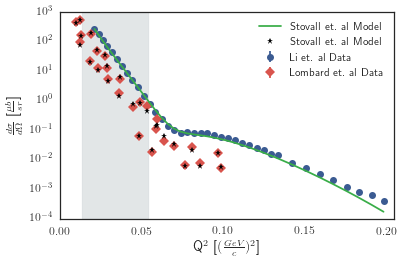

In [92]:
pp.figure(figsize=plot_size)
pp.errorbar(li_calc_qq, 
            li_data.xsection*1000, #Convert to mu barns/sr 
            yerr=li_data.xsection_err, 
            ls='None', 
            marker='o',
            label='Li et. al Data', 
            color=sns.xkcd_rgb['denim blue'])
pp.errorbar(lombard_calc_qq, 
            lombard_data.xsection, 
            yerr=lombard_data.xsection_err, 
            ls='None', marker='D', 
            label='Lombard et. al Data', 
            color=sns.xkcd_rgb['pale red'])
pp.plot(li_calc_qq, 
        li_stovall_xsection, 
        ls='-', 
        color=sns.xkcd_rgb['medium green'], 
        label='Stovall et. al Model')
pp.plot(lombard_calc_qq, 
        lombard_stovall_xsection, 
        ls='None', 
        marker='*', 
        color=sns.xkcd_rgb['black'], 
        label='Stovall et. al Model')
pp.yscale('log')
pp.xlim(0.00, 0.205)
[y_low,y_high] = pp.ylim()
pp.fill_between(qweak_calc_qq, 
                y_low, 
                y_high, 
                color=sns.xkcd_rgb['steel grey'],
                alpha=0.2)
pp.legend(loc='upper right', fontsize=11)
pp.xlabel('Q$^{2}$ [$(\\frac{GeV}{c})^{2}$]',fontsize=14)
pp.ylabel('$\\frac{d\\sigma}{d\\Omega}$ [$\\frac{\\mu b}{sr}$]', fontsize=14)
pp.xticks(fontsize=12)
pp.yticks(fontsize=12)
pp.savefig('elastic_cross_section_compare_plot.png', bbox_inches='tight')
pp.savefig('elastic_cross_section_compare_plot.pdf', bbox_inches='tight')
pp.show()

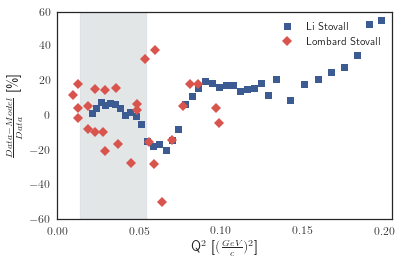

In [94]:
pp.figure(figsize=plot_size)
pp.plot(li_calc_qq, 
        li_stovall_pdiff, 
        ls='None', 
        marker = 's', 
        color=sns.xkcd_rgb['denim blue'], 
        label='Li Stovall')
pp.plot(lombard_calc_qq, 
        lombard_stovall_pdiff, 
        ls='None', 
        marker='D', 
        color=sns.xkcd_rgb['pale red'], 
        label='Lombard Stovall')
#pp.yscale('log')
pp.xlim(0.00, 0.205)
[y_low,y_high] = pp.ylim()
pp.fill_between(qweak_calc_qq, 
                y_low, 
                y_high, 
                color=sns.xkcd_rgb['steel grey'],
                alpha=0.2)
pp.legend(loc='upper right', fontsize=11)
pp.xlabel('Q$^{2}$ [$(\\frac{GeV}{c})^{2}$]',fontsize=14)
pp.ylabel('$\\frac{Data-Model}{Data}$ [\%]', fontsize=14)
pp.xticks(fontsize=12)
pp.yticks(fontsize=12)
pp.savefig('elastic_cross_section_pdiff_plot.png', bbox_inches='tight')
pp.savefig('elastic_cross_section_pdiff_plot.pdf', bbox_inches='tight')
pp.show()